In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Reading Dataset...
movies_data = pd.read_csv('tmdb-movies-5k/tmdb_5000_movies.csv')
credits_data = pd.read_csv('tmdb-movies-5k/tmdb_5000_credits.csv')

In [3]:
# Showing the movies data Structure...
movies_data.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [4]:
# Showing the credits data Structure...
credits_data.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [5]:
# Merging the 2 csv files ('movies', 'credits')
movies_data = movies_data.merge(credits_data, on='title')

## Data Visualization

In [6]:
# These are some helper functions to deal with multi-hot features
# ----------------------------------------------------------------------------------------------------------------- #
saving=False

import matplotlib.pyplot as plt
# numbers of movies released in each decade
def count_pie(series, filename):
    counts=series.value_counts()
    counts=counts/counts.sum()
    labels=['' if num<0.01 else str(year) for (year,num) in counts.items()]
    f, ax = plt.subplots(figsize=(8, 8))
    explode = [0.02 if counts.iloc[i] < 100 else 0.001 for i in range(counts.size)]
    plt.pie(counts,labels=labels,autopct=lambda x:'{:1.0f}%'.format(x) if x > 1 else '',explode=explode)
    if saving:plt.savefig(filename,dpi=150)
    plt.show()

def count_decade_pie(df, filename):
    count_pie(df.release_date.dropna().apply(lambda x:str(int(x[:4])//10*10)+'s'), filename)
# ----------------------------------------------------------------------------------------------------------------- #

# ----------------------------------------------------------------------------------------------------------------- #
import seaborn as sns
# numbers of movies of different genres and keywords
def multi_count(series,index="id"):
    return {k:len(v) for (k,v) in group_indices(series,index).items()}

def group_indices(series,index="id"):
    d={}
    for i in range(series.size):
        l=eval(series.iloc[i])
        for x in l:
            d.setdefault(x[index],[])
            d[x[index]].append(i)
    return d

def multi_bar(series,filename):    
    sns.set(style="whitegrid")
    count=multi_count(series,"name")
    count=sorted(count.items(),key=lambda x:x[1],reverse=True)
    count=dict(count[:30])
    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation=85, fontsize=15)
    plt.bar(count.keys(),count.values(),align="center")
#     plt.pie(count.values(),labels=count.keys())
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=100)
    plt.show()
    
import wordcloud as wc
# wordcloud of genres and keywords
def multi_wordcloud(series,filename):
    w=wc.WordCloud(background_color="white",margin=20,width=800,height=600,prefer_horizontal=0.7,max_words=50,scale=2)
    count=multi_count(series,"name")
    w.generate_from_frequencies(count)
    if saving:w.to_file(filename)
    f, ax = plt.subplots(figsize=(16, 8))
    plt.axis('off')
    plt.imshow(w)
    plt.show()
# ----------------------------------------------------------------------------------------------------------------- #

# ----------------------------------------------------------------------------------------------------------------- #
# distribution of popularity and runtime groupby genres
def expand_multi_feature(df,column,index="id"):
    groups=group_indices(df[column],index=index)
    result=pd.DataFrame()
    for name,indices in groups.items():
        rows=df.iloc[indices].copy()
        rows[column]=name
        result=result.append(rows)
    return result

def plotby_box(df,x,y,filename,yscale="linear"):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    sns.boxenplot(data=expand_multi_feature(df,x,"name"),x=x,y=y)
    plt.yscale(yscale)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()
# ----------------------------------------------------------------------------------------------------------------- #

# ----------------------------------------------------------------------------------------------------------------- #
# average budget and revenue of each genres' movies
def multi_groupby(df,column,index="id"):
    return expand_multi_feature(df,column,index).groupby(column)

def plotby_2bar(df,x,y,filename):
    sns.set(style="whitegrid")
    df=df.replace(0,np.nan).copy()
    f,ax=plt.subplots(figsize=(20, 10))
    multi_groupby(df.dropna(subset=y),x,"name")[y].mean().sort_values(y,ascending=False).plot(kind="bar",ax=ax)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55,fontsize=20)
    plt.xlabel(x,fontsize=30)
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=150)
    plt.show()
# ----------------------------------------------------------------------------------------------------------------- #

# ----------------------------------------------------------------------------------------------------------------- #
# correlation between numeric features
data=movies_data.dropna(subset=["vote_count"]).copy()
data["release_year"]=pd.DatetimeIndex(data['release_date']).year
data=data[data.vote_count>=100].copy()

def plot_corr(df,filename):
    plt.subplots(figsize=(12, 9))
    sns.heatmap(df.corr(),annot=True,linewidths=.5,annot_kws={"fontsize":15})
    plt.yticks(rotation=0,fontsize=15)
    plt.xticks(rotation=0,fontsize=15)
    if saving:plt.savefig(filename,dpi=150)
    plt.show()
# ----------------------------------------------------------------------------------------------------------------- #

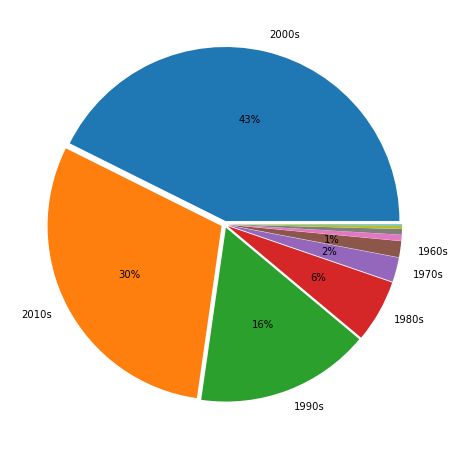

In [7]:
count_decade_pie(movies_data, filename="pie_decade.png")

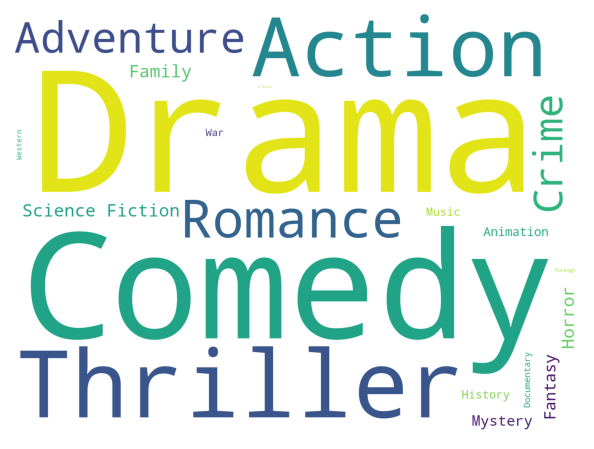

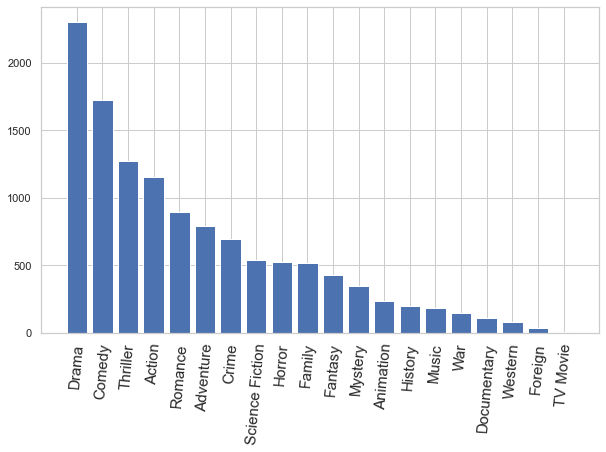

In [8]:
multi_wordcloud(movies_data.genres,filename="wordcloud_genres.png")
multi_bar(movies_data.genres,filename="bar_genres.png")

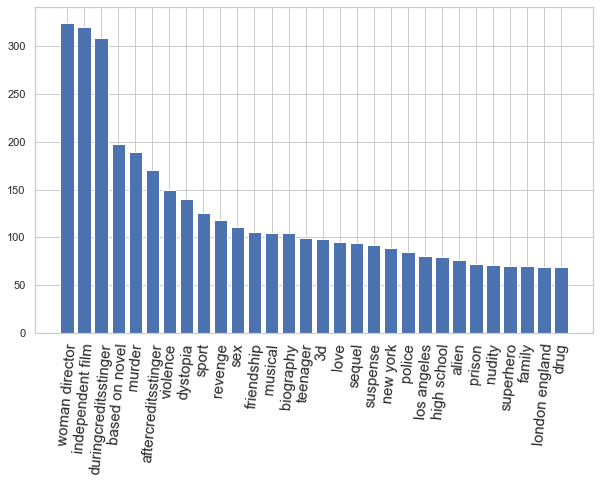

In [9]:
multi_bar(movies_data.keywords,filename="bar_keywords.png")

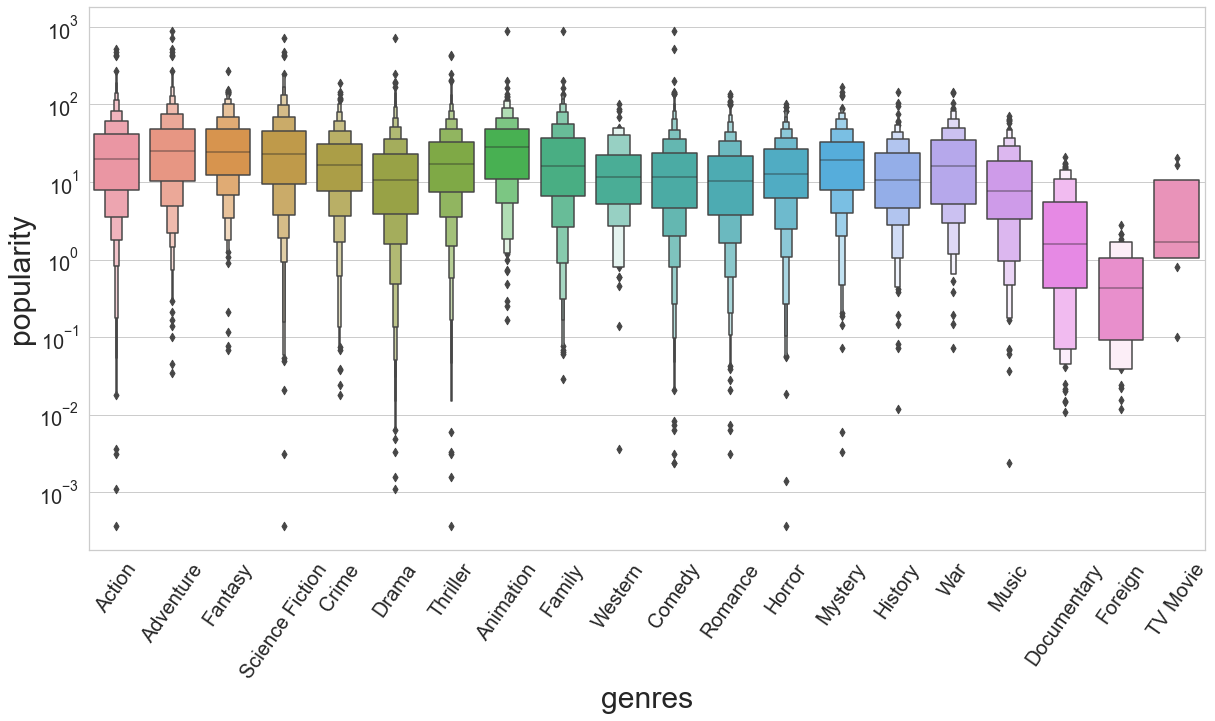

In [10]:
plotby_box(movies_data, "genres", "popularity", yscale="log", filename="genres_popularity.png")

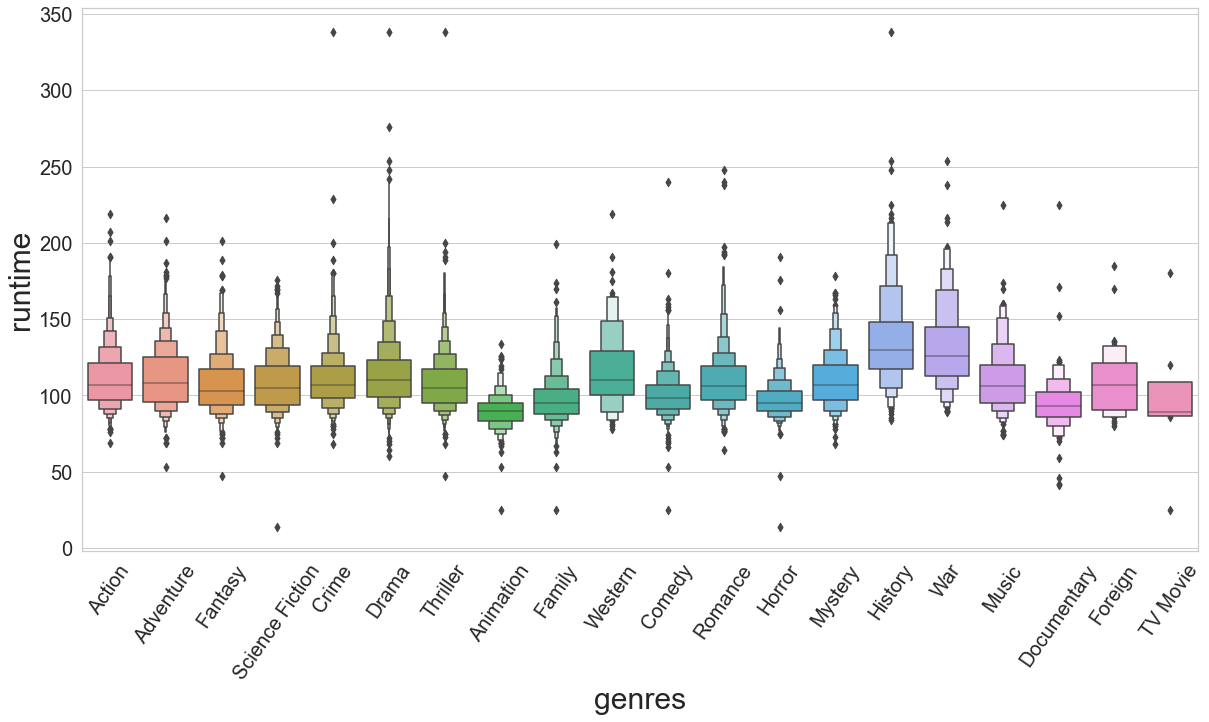

In [11]:
plotby_box(movies_data, "genres", "runtime", yscale="linear", filename="genres_runtime.png")

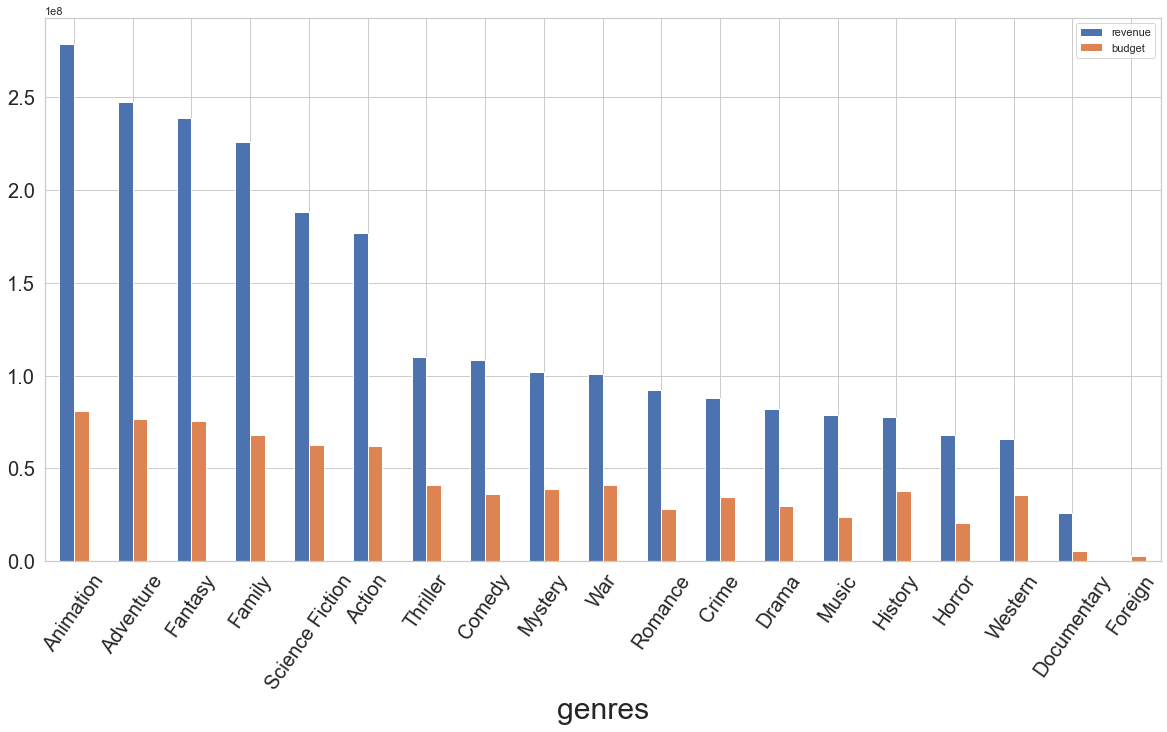

In [12]:
plotby_2bar(movies_data,"genres", ["revenue","budget"], filename="genres_budget_revenue.png")

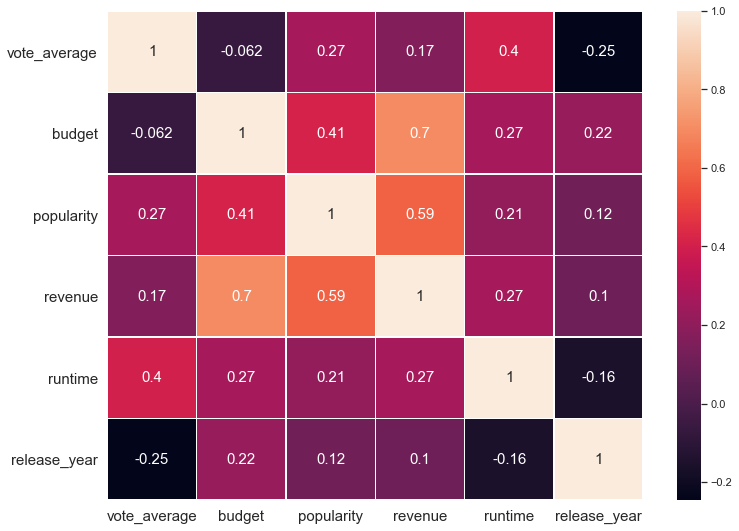

In [13]:
plot_corr(data[["vote_average", "budget", "popularity", "revenue", "runtime", "release_year"]], filename="corr.png")

# Data Cleaning

In [14]:
# The Shape of the merged 2 csv files
# Should be 4809 samples and 23 features
movies_data.shape

(4809, 23)

In [15]:
# Structure of the merged dataframe
movies_data.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [16]:
# We are not interested in the 23 features, otherwise in:
# [movie_id - title - overview - genres - keywords - cast - crew]
movies_data = movies_data[['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew']]

In [17]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4809 entries, 0 to 4808
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4809 non-null   int64 
 1   title     4809 non-null   object
 2   overview  4806 non-null   object
 3   genres    4809 non-null   object
 4   keywords  4809 non-null   object
 5   cast      4809 non-null   object
 6   crew      4809 non-null   object
dtypes: int64(1), object(6)
memory usage: 300.6+ KB


In [18]:
movies_data.head(3)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


In [19]:
movies_data.isnull().sum()

movie_id    0
title       0
overview    3
genres      0
keywords    0
cast        0
crew        0
dtype: int64

In [20]:
# Dropping the 3 samples of overview = null
movies_data = movies_data.dropna()

In [21]:
# Exploring if there any data duplications
movies_data.duplicated().sum()

0

In [22]:
# Displaying genres sample
movies_data.iloc[0].genres

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

#### Extracting Genres Feature

In [23]:
import ast  # to overcome "string indices must be integers" error

In [24]:
def extract_names(obj):
    names = []
    for name in ast.literal_eval(obj):
        names.append(name['name'])
    return names

In [25]:
movies_data['genres'] = movies_data['genres'].apply(extract_names)

In [26]:
movies_data.head(3)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


#### Extracting Keywords Feature

In [27]:
movies_data['keywords'] = movies_data['keywords'].apply(extract_names)

In [28]:
movies_data.head(3)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


### Extracting Credits Features

In [29]:
# movies_data['cast'][0]
# movies_data['crew'][0]

# in the credits.csv file the 2 features (cast and crew)
# are objects in the shape of list of dictionary list, containing 
# much more data that we may need such as ('Editing', 'Production', 'Sound', 'Costume Design', etc..)
# in the cast feature we are gonna use only the actor name attribute
# in the crew feature we are gonna use only the director attribute

# [N.B] Uncomment any of the first 2 lines to get the point :)

#### Extracting Cast Feature

In [30]:
# Extract only the first 3 actors
def extract_actors_names(obj):
    names = []
    n_actors = 0
    for name in ast.literal_eval(obj):
        if n_actors < 3:
            names.append(name['name'])
            n_actors = n_actors + 1
        else:
            break
    return names

In [31]:
movies_data['cast'] = movies_data['cast'].apply(extract_actors_names)

In [32]:
movies_data.head(3)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


#### Extracting Crew Feature

In [33]:
# Extract only the directors names
def extract_directors_names(obj):
    names = []
    for job in ast.literal_eval(obj):
        if job['job'] == 'Director':
            names.append(job['name'])
    return names

In [34]:
movies_data['crew'] = movies_data['crew'].apply(extract_directors_names)

In [35]:
movies_data.head(3)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron]
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski]
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes]


#### Preprocess Overview Feature

In [36]:
# Converting Overview Column from string to list object
# to help us append to it in the upcoming fields...
movies_data['overview'] = movies_data['overview'].apply(lambda i:i.split())

In [37]:
movies_data.head(3)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron]
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski]
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes]


#### Preprocess [Genres, Keywords, Cast, Crew] Features

In [38]:
# Removing all the white spaces to handle 
# future issues when comparing two strigns.
movies_data['genres'] = movies_data['genres'].apply(lambda i:[j.replace(" ", "") for j in i])
movies_data['keywords'] = movies_data['keywords'].apply(lambda i:[j.replace(" ", "") for j in i])
movies_data['cast'] = movies_data['cast'].apply(lambda i:[j.replace(" ", "") for j in i])
movies_data['crew'] = movies_data['crew'].apply(lambda i:[j.replace(" ", "") for j in i])

In [39]:
movies_data.head(3)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron]
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski]
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes]


## New DataFrame Creation

In [40]:
movies_data['tags'] = movies_data['overview'] + movies_data['genres'] + movies_data['keywords'] + movies_data['cast'] + movies_data['crew'] 

In [41]:
movies_data.head(2)

,movie_id,title,overview,genres,keywords,cast,crew,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron],"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski],"[Captain, Barbossa,, long, believed, to, be, d..."


In [42]:
df = movies_data[['movie_id', 'title', 'tags']]

In [43]:
# Now 'df' contains the feature 'tags' which holds the previous 5 features
df

,movie_id,title,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili..."
...,...,...,...
4804,9367,El Mariachi,"[El, Mariachi, just, wants, to, play, his, gui..."
4805,72766,Newlyweds,"[A, newlywed, couple's, honeymoon, is, upended..."
4806,231617,"Signed, Sealed, Delivered","[""Signed,, Sealed,, Delivered"", introduces, a,..."
4807,126186,Shanghai Calling,"[When, ambitious, New, York, attorney, Sam, is..."


In [44]:
# Converting tags from List object back to string
df['tags'] = df['tags'].apply(lambda i:" ".join(i))

In [45]:
df['tags'] = df['tags'].apply(lambda i:i.lower())

In [46]:
df.head(2)

,movie_id,title,tags
0,19995,Avatar,"in the 22nd century, a paraplegic marine is di..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha..."


In [47]:
# All the 5 features in one string. (lower case)
df['tags'][0]

'in the 22nd century, a paraplegic marine is dispatched to the moon pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. action adventure fantasy sciencefiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d samworthington zoesaldana sigourneyweaver jamescameron'

In [48]:
df.to_csv('tmdb-movies-5k/cleaned_merged_movies.csv', index=False)

# Applying NLP Techniques

In [49]:
import nltk
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

In [50]:
def stem_text(text):
    bag = []
    for word in text.split():
        bag.append(stemmer.stem(word))
    return " ".join(bag)

In [51]:
df['tags'] = df['tags'].apply(stem_text)

### Feature Extraction

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=5000)

In [53]:
vectors = vectorizer.fit_transform(df['tags']).toarray()

In [54]:
vectors  # 4806 x 5000

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [55]:
# vectorizer.get_feature_names()

In [56]:
from sklearn.metrics.pairwise import cosine_similarity

In [57]:
sim = cosine_similarity(vectors)

In [58]:
sim[2]

array([0.0860309 , 0.06063391, 1.        , ..., 0.02451452, 0.        ,
       0.        ])

# NLP Model Evaluation

In [59]:
def get_recommendations(movie_name, top_n=10):
    movie_idx = df[df['title'] == movie_name].index[0]
    distances = sim[movie_idx]
    movies_recommended_info_list = sorted(list(enumerate(distances)), reverse=True, key = lambda i:i[1])[1:1+top_n]
    recommended_movies = []
    for movie in movies_recommended_info_list:
        recommended_movies.append((df.iloc[movie[0]].movie_id, df.iloc[movie[0]].title, movie[1]))  # id, title, similarity
    return recommended_movies

### Performance Evaluation on the Train Data

In [60]:
# for each movie in the database
# calculate the number of movies which has 
# distance value greater than THRESHOLD value (relevant movies).
def evaluate_performance(sim_thresh=0.1, n_retrieval=10, data=df):
    db_movies = data['title']
    thresh = sim_thresh
    percision_acc = 0
    recall_acc = 0
    it = 0
    
    for movie in db_movies:
        if data[data['title'] == movie].index[0] == len(db_movies):
            break
        mv_rec = get_recommendations(movie, top_n=n_retrieval)
        strong_relevant = 0
        weak_relevant = 0
        it += 1
        
        for rec in mv_rec:
            if rec[2] > thresh:
                strong_relevant+=1
            elif rec[2] > 0:
                weak_relevant+=1
            else:
                break
                
        percision_acc += strong_relevant / n_retrieval
        recall_acc += strong_relevant / (strong_relevant + weak_relevant)
    return percision_acc/it, recall_acc/it

In [61]:
from prettytable import PrettyTable

In [62]:
avg_percision, avg_recall = evaluate_performance(sim_thresh=0.15, n_retrieval=10)
f1_score = 2 * (avg_percision * avg_recall) / (avg_percision + avg_recall)
tbl = PrettyTable(['Average Percision', 'Average Recall', 'F1-Score'])
tbl.add_row([avg_percision, avg_recall, f1_score])
print(tbl)

+--------------------+--------------------+--------------------+
| Average Percision  |   Average Recall   |      F1-Score      |
+--------------------+--------------------+--------------------+
| 0.9920674578388506 | 0.9920674578388506 | 0.9920674578388506 |
+--------------------+--------------------+--------------------+


### Performance Evaluation on the Test Data

In [63]:
# Reading TEST Data...
test_data = pd.read_csv('tmdb-movies-5k/cleaned_merged_test.csv')
test_data

,movie_id,title,tags
0,354912,Coco,despite his family’s baffling generations-old ...
1,696806,The Adam Project,"after accidentally crash-landing in 2022, time..."
2,568124,Encanto,"the tale of an extraordinary family, the madri..."
3,646380,Don't Look Up,two low-level astronomers must go on a giant m...
4,508943,Luca,luca and his best friend alberto experience an...
5,639933,The Northman,prince amleth is on the verge of becoming a ma...


In [64]:
# Merging train and test data in one dataframe
org_df = df.copy()
org_sim = cosine_similarity(vectors)
df = df.append(test_data)
df

,movie_id,title,tags
0,19995,Avatar,"in the 22nd century, a parapleg marin is dispa..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believ to be dead, ha c..."
2,206647,Spectre,a cryptic messag from bond’ past send him on a...
3,49026,The Dark Knight Rises,follow the death of district attorney harvey d...
4,49529,John Carter,"john carter is a war-weary, former militari ca..."
...,...,...,...
1,696806,The Adam Project,"after accidentally crash-landing in 2022, time..."
2,568124,Encanto,"the tale of an extraordinary family, the madri..."
3,646380,Don't Look Up,two low-level astronomers must go on a giant m...
4,508943,Luca,luca and his best friend alberto experience an...


In [65]:
df['tags'] = df['tags'].apply(stem_text)
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
vectors = vectorizer.fit_transform(df['tags']).toarray()
sim = cosine_similarity(vectors)

In [66]:
avg_percision, avg_recall = evaluate_performance(sim_thresh=0.20, n_retrieval=10, data=test_data)
f1_score = 2 * (avg_percision * avg_recall) / (avg_percision + avg_recall)
tbl = PrettyTable(['Average Percision', 'Average Recall', 'F1-Score'])
tbl.add_row([avg_percision, avg_recall, f1_score])
print(tbl)

+--------------------+--------------------+--------------------+
| Average Percision  |   Average Recall   |      F1-Score      |
+--------------------+--------------------+--------------------+
| 0.9166666666666666 | 0.9166666666666666 | 0.9166666666666666 |
+--------------------+--------------------+--------------------+


### Recommend For a Single Movie

In [67]:
recommendations = get_recommendations('Superman')

In [68]:
# Printing movies in a tabluar form
tbl = PrettyTable(['Movie ID', 'Movie Title', 'Similarity'])
for movie in recommendations:
    tbl.add_row([movie[0], movie[1], movie[2]])
print(tbl)

+----------+----------------------------------+---------------------+
| Movie ID |           Movie Title            |      Similarity     |
+----------+----------------------------------+---------------------+
|   1452   |         Superman Returns         |  0.3839908587347318 |
|   8536   |           Superman II            |  0.3750814067088717 |
|  10138   |            Iron Man 2            | 0.32923769125601826 |
|   9531   |           Superman III           |  0.323047869190461  |
|  11411   | Superman IV: The Quest for Peace | 0.31094670840846167 |
|  102899  |             Ant-Man              |  0.309294787065871  |
|   2661   |              Batman              |  0.2777919497518579 |
|   558    |           Spider-Man 2           | 0.27472112789737807 |
|  76170   |          The Wolverine           | 0.26949777665251384 |
|   268    |              Batman              | 0.26190476190476186 |
+----------+----------------------------------+---------------------+


# Data Saving

In [69]:
import pickle

In [70]:
pickle.dump(org_df.to_dict(), open('movies_dict.pkl', 'wb'))

In [71]:
pickle.dump(org_sim, open('nlp_model.pkl', 'wb'))